# Charts and diagrams

In this notebook, we will show you how to draw basic financial charts.

We will

* Download daily candle data for all pairs

* Extract data for ETH-USDC pair on Uniswap v2

* Draw standard basic price charts like OHLC and OHLCV

* Plot charts as static images using [mplfinance](https://pypi.org/project/mplfinance/)

## Setup

First let's install Capitalgram package, the package dependencies and initialise our dataset client.
This might take 5 minutes in a fresh environment.

In [1]:
from tradingstrategy.client import Client
client = await Client.create_jupyter_lite_client(api_key=globals().get("api_key",None))
if client==None:
    api_key=await input("Please enter an api key then re-run the notebook")


No existing Trading Strategy configuration found in /home/pyodide/.tradingstrategy/settings.json. Making config from keyword parameters.
Testing out API key: secret-token:tradingstra
The server replied accepted our API key and sent the following greetings:
Server version: 0.1
Message of the day: Han shot first
The API key setup complete.


## Fetch data

Let's download 1 day (24h) candles to all trading pairs. This dataset is several dozens of megabytes.
You should see a progress bar during the download.

**Note**: We could also query live candle datasets for trading pairs we are interested in.
However, the bundled dataset is faster for the future analysis, as after the download
it will have all candles cached in your local notebook environment.

In [2]:
from tradingstrategy.timebucket import TimeBucket

# Download all 24h candles as Parquet columnar data
all_candles = client.fetch_all_candles(TimeBucket.d1)
exchanges=client.fetch_exchange_universe()
pair_universe=client.fetch_pair_universe()

100%|##########| 32.0M/32.0M [00:00<00:00, 54.2MB/s]
Missing HTTP response content-length header for download https://tradingstrategy.ai/api/exchange-universe, headers are ItemsView({'content-type': 'application/json'})
(Unknown total file size): 1.60MB [00:00, 10.1MB/s]
100%|##########| 13.2M/13.2M [00:00<00:00, 52.1MB/s]


Let's pick one pair, ETH-USDC on Uniswap v2, from the dataset to analyse.

In [3]:
import pandas as pd
from tradingstrategy.chain import ChainId

# Convert PyArrow table to Pandas format to continue working on it
all_candles_dataframe = all_candles.to_pandas()
pairs = pair_universe.to_pandas()
exchange_id=exchanges.get_by_chain_and_slug(ChainId.ethereum,"pancakeswap").exchange_id
# select the pair ID by the tokens used and the exchange
pair_id = pairs.query("token0_symbol == 'ETH' & token1_symbol=='USDC' & exchange_id==@exchange_id").iloc[0]['pair_id']
eth_usdc_pair: pd.DataFrame = all_candles_dataframe.query("pair_id == @pair_id")

print(f"PancakeSwap ETH-USDC has {len(eth_usdc_pair)} daily candles")

PancakeSwap ETH-USDC has 15 daily candles


## Static charts with mplfinance

[mplfinance](https://pypi.org/project/mplfinance/) is a Jupyter Notebook library for financial charts.
It creates static charts out from Pandas data.

Pros

* Static chart images can be saved with notebook and are displayed e.g. on Github and the documentation website

Cons

* There is no interactive explorer controls like dragging timeline or zooming in.

Below we create a simple static chart from ETH-USDC price.

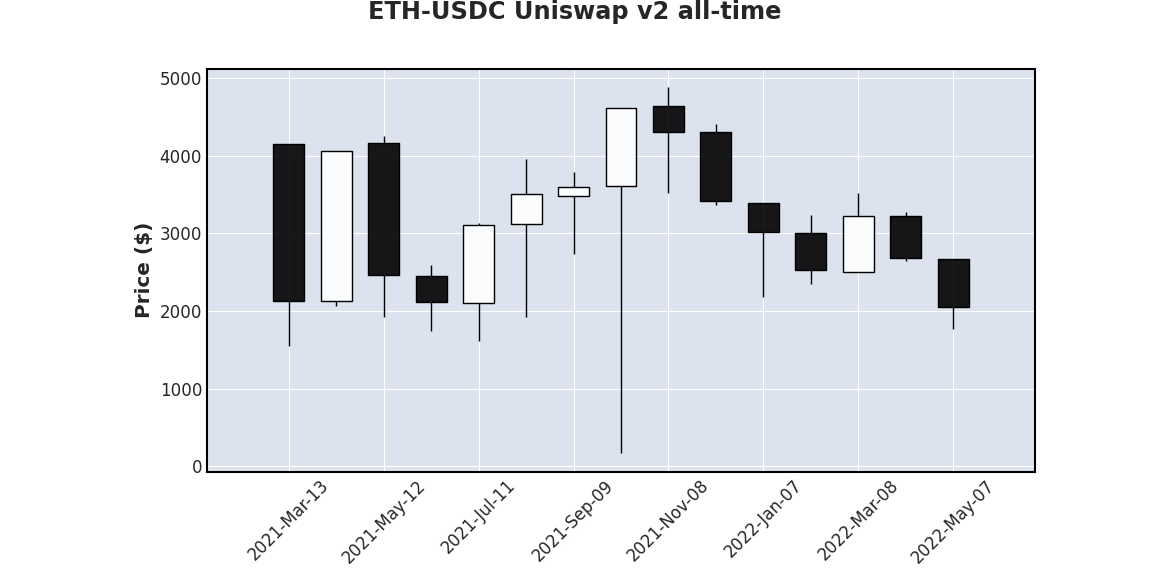

In [4]:
import mplfinance as fplt

# Add a time based index to data series, as needed by mplfinance,
# so it knows which column is the x axis
eth_usdc_pair = eth_usdc_pair.set_index(pd.DatetimeIndex(eth_usdc_pair["timestamp"]))

fig=fplt.plot(
            eth_usdc_pair,
            type='candle',
            title='ETH-USDC Uniswap v2 all-time',
            ylabel='Price ($)',
            figratio=(20, 10),  # Setting chart ratio makes us to use more horizontal space
        )



As the daily candles are not that readable due to scale of the diagram, let's zoom in to March 2021, a randomly chosen month.

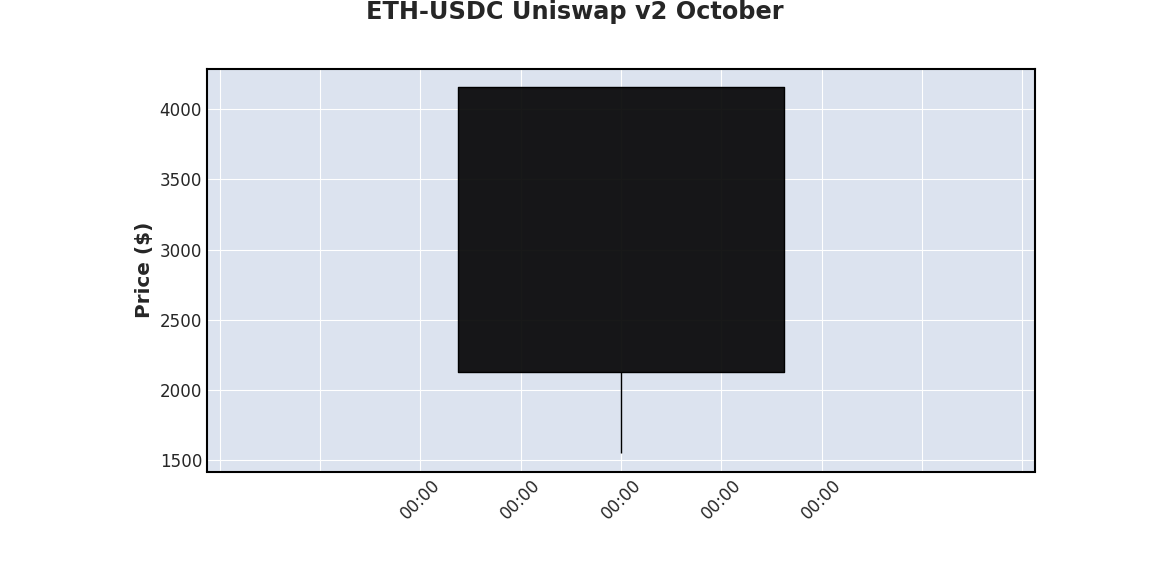

In [6]:
# Our filtering mask for the data
mask = (eth_usdc_pair.timestamp >= "2021-03-1") & (eth_usdc_pair.timestamp <= "2021-04-1")
october = eth_usdc_pair[mask]

# october = eth_usdc_pair.set_index(pd.DatetimeIndex(eth_usdc_pair["timestamp"]))

fig=fplt.plot(
            october,
            type='candle',
            title='ETH-USDC Uniswap v2 March',
            ylabel='Price ($)',
            figratio=(20, 10),
        )



That's all for the basic charts.